[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/source/data_augmentation_sequential.ipynb)

# Augmentation Sequential

In this tutorial we will show how we can quickly perform **data augmentation for various tasks** (segmentation, detection, regression) using the features provided by the `kornia.augmentation.AugmentationSequential` API.

## Install and get data

We install Kornia and some dependencies, and download a simple data sample

In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url = "https://raw.githubusercontent.com/kornia/data/main/panda.jpg"
download_image(url)

'panda.jpg'

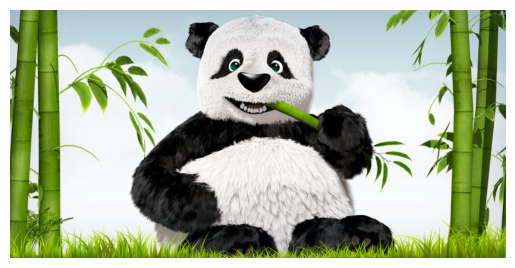

In [ ]:
import cv2
import numpy as np
import torch
from kornia import augmentation as K
from kornia.augmentation import AugmentationSequential
from kornia.geometry import bbox_to_mask
from kornia.utils import image_to_tensor, tensor_to_image
from matplotlib import pyplot as plt
from torchvision.transforms import transforms

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()


def plot_resulting_image(img, bbox, keypoints, mask):
    img = img * mask
    img_draw = cv2.polylines(np.array(to_pil(img)), bbox.numpy(), isClosed=True, color=(255, 0, 0))
    for k in keypoints[0]:
        img_draw = cv2.circle(img_draw, tuple(k.numpy()[:2]), radius=6, color=(255, 0, 0), thickness=-1)
    return img_draw


img = cv2.imread("panda.jpg", cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
h, w = img.shape[:2]

img_tensor = image_to_tensor(img).float() / 255.0
plt.imshow(img)
plt.axis("off");

## Define Augmentation Sequential and Different Labels

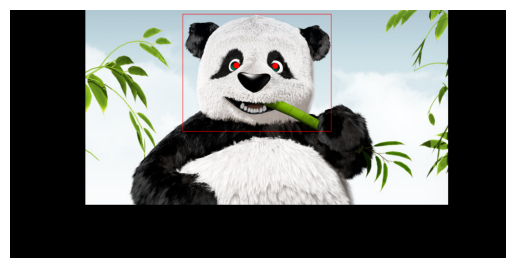

In [ ]:
aug_list = AugmentationSequential(
    K.ColorJitter(0.1, 0.1, 0.1, 0.1, p=1.0),
    K.RandomAffine(360, [0.1, 0.1], [0.7, 1.2], [30.0, 50.0], p=1.0),
    K.RandomPerspective(0.5, p=1.0),
    data_keys=["input", "bbox", "keypoints", "mask"],
    same_on_batch=False,
)

bbox = torch.tensor([[[[355, 10], [660, 10], [660, 250], [355, 250]]]])
keypoints = torch.tensor([[[465, 115], [545, 116]]])
mask = bbox_to_mask(torch.tensor([[[155, 0], [900, 0], [900, 400], [155, 400]]]), w, h)[None].float()

img_out = plot_resulting_image(img_tensor, bbox[0], keypoints, mask[0])

plt.imshow(img_out)
plt.axis("off");

## Forward Computations

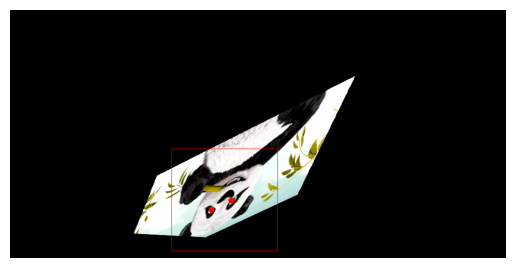

In [ ]:
out_tensor = aug_list(img_tensor, bbox.float(), keypoints.float(), mask)
img_out = plot_resulting_image(
    out_tensor[0][0],
    out_tensor[1].int(),
    out_tensor[2].int(),
    out_tensor[3][0],
)
plt.imshow(img_out)
plt.axis("off");

## Inverse Transformations

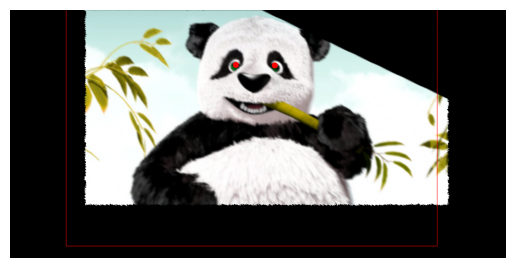

In [ ]:
out_tensor_inv = aug_list.inverse(*out_tensor)
img_out = plot_resulting_image(
    out_tensor_inv[0][0],
    out_tensor_inv[1].int(),
    out_tensor_inv[2].int(),
    out_tensor_inv[3][0],
)
plt.imshow(img_out)
plt.axis("off");